## **Mounting Google Drive**
This cell mounts Google Drive to Google Colab so that files can be accessed and stored directly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Installing Required Libraries**
The `datasets` library is used to load NLP datasets such as CoNLL-2003, which is used for Named Entity Recognition (NER).

In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.8 MB/s eta 0:00:00


## **Loading and Exploring the CoNLL-2003 Dataset**
- The `load_dataset()` function loads the dataset.
- `trust_remote_code=True` is used to allow loading remote datasets.
- The dataset contains four features: `tokens`, `pos_tags`, `chunk_tags`, and `ner_tags`.
- A sample sentence with its NER tags is printed for inspection.

In [5]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from collections import defaultdict

from datasets import load_dataset

# Load CoNLL-2003 dataset with trust_remote_code enabled
dataset = load_dataset("conll2003", trust_remote_code=True)

# Print dataset details
print(dataset)


# View a sample from the training set
print(dataset["train"][0])

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


## **Visualizing the Distribution of NER Labels**
- Extracts all NER labels from the dataset.
- Uses `Counter()` to count occurrences of each label.
- Plots a bar chart showing the frequency of each NER label.

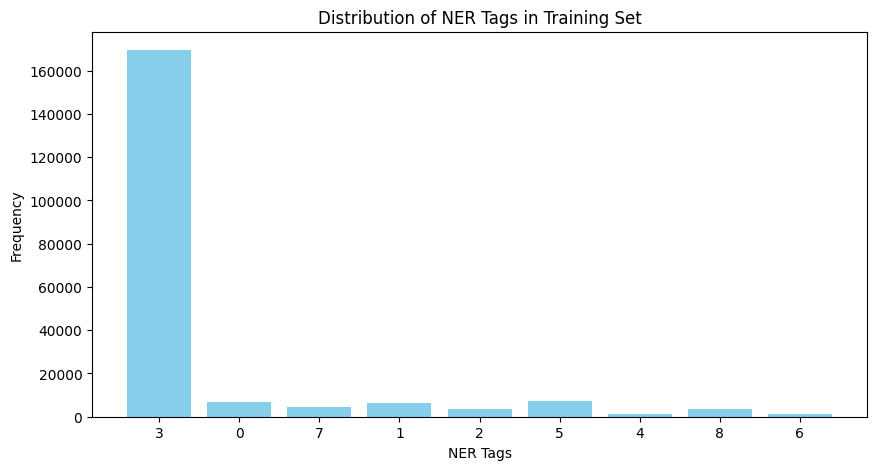

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset

# Load dataset
dataset = load_dataset("conll2003")  # Replace with your dataset if different

# Extract NER labels
ner_tags = dataset['train']['ner_tags']
all_labels = [label for tags in ner_tags for label in tags]

# Count label occurrences
label_counts = Counter(all_labels)

# Plot label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("NER Tags")
plt.ylabel("Frequency")
plt.title("Distribution of NER Tags in Training Set")
plt.xticks(ticks=range(len(label_counts)), labels=label_counts.keys())
plt.show()

## **Loading the BERT Tokenizer**
- Uses `BertTokenizerFast` for efficient tokenization.
- Loads the `bert-base-uncased` tokenizer, which is pretrained and does not differentiate between uppercase and lowercase letters.
"""
## **Function to Tokenize and Align Labels**
This function tokenizes the sentences and aligns their NER labels properly:
- Tokenizes each word while keeping track of word boundaries.
- Ensures that subword tokens receive the same label as the original word.
- Special tokens like `[CLS]` and `[SEP]` are ignored (-100).
"""

In [8]:
from transformers import BertTokenizerFast

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        previous_word = None
        aligned_labels = []
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)  # Ignore special tokens
            elif word_id != previous_word:
                aligned_labels.append(label[word_id])
            else:
                aligned_labels.append(label[word_id])  # Use same label for subword tokens
            previous_word = word_id
        labels.append(aligned_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply function to dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [9]:
# Check sample tokenized input
sample = tokenized_dataset['train'][0]
tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'])

print("Tokens:", tokens)
print("Labels:", sample['labels'])

Tokens: ['[CLS]', 'eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.', '[SEP]']
Labels: [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]


## **Function to Convert Label IDs to Names**
This function converts numerical label IDs into their corresponding NER tag names:
- Uses a predefined mapping of label indices to tag names.
- Helps in better visualization and understanding of the NER output.


In [10]:
# Define label mapping for CoNLL-2003 dataset
label_mapping = {
    0: "O",        # Outside any named entity
    1: "B-PER",    # Beginning of a person entity
    2: "I-PER",    # Inside a person entity
    3: "B-ORG",    # Beginning of an organization entity
    4: "I-ORG",    # Inside an organization entity
    5: "B-LOC",    # Beginning of a location entity
    6: "I-LOC",    # Inside a location entity
}

# Function to convert labels to their corresponding names
def convert_labels_to_names(labels):
    return [label_mapping[label] if label in label_mapping else "Unknown" for label in labels]

# Example usage with a sample from the tokenized dataset
sample = tokenized_dataset['train'][0]  # Change index as needed for different samples
tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'])
labels = sample['labels']
label_names = convert_labels_to_names(labels)

# Display tokens and their corresponding labels
for token, label_name in zip(tokens, label_names):
    print(f"Token: {token}, Label: {label_name}")

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Sample from Training Data:
Tokens: ['[CLS]', 'eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.', '[SEP]']
Labels: [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]

Sample from Validation Data:
Tokens: ['[CLS]', 'cricket', '-', 'leicestershire', 'take', 'over', 'at', 'top', 'after', 'innings', 'victory', '.', '[SEP]']
Labels: [-100, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, -100]

Sample from Test Data:
Tokens: ['[CLS]', 'soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.', '[SEP]']
Labels: [-100, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, -100]


## **Loading the Trained Model and Tokenizer for Inference**
This section loads the trained NER model and tokenizer from the saved directory and performs inference on an example text:
- `pipeline("ner", model=model_path, tokenizer=model_path)`: Loads the model and tokenizer into an inference pipeline.
- `text`: Defines an example sentence for Named Entity Recognition.
- `ner_pipeline(text)`: Performs NER on the input text and returns the results.
- The results are printed with the entity name, its recognized type, and the confidence score.

In [ ]:
# Load the trained model and tokenizer for inference
from transformers import pipeline

# Load your trained model from the saved directory
model_path = "./my_ner_model"
ner_pipeline = pipeline("ner", model=model_path, tokenizer=model_path)

# Example text for inference
text = "Apple CEO Tim Cook announced new iPhone models in California yesterday."

# Perform NER on the input text
results = ner_pipeline(text)

# Display results with corresponding labels
for entity in results:
    print(f"Entity: {entity['word']}, Type: {entity['entity']}, Confidence: {entity['score']:.4f}")

"""
## **Computing Evaluation Metrics for NER**
This section defines a function to calculate precision, recall, and F1-score for Named Entity Recognition (NER) predictions.

### **Function: compute_metrics(predictions, references)**
- **Args:**
  - `predictions (list)`: List of predicted labels for tokens.
  - `references (list)`: List of true labels for tokens.

- **Steps:**
  1. **Flatten the lists**: Since NER predictions are made at the sentence level, we flatten the lists to a single sequence for metric computation.
  2. **Filter out ignored tokens (`-100`)**: Some tokens (like subwords and special tokens) are ignored during training. These must be removed before calculating metrics.
  3. **Compute Precision, Recall, and F1-score**: Uses `precision_score`, `recall_score`, and `f1_score` from `sklearn.metrics` to evaluate the model.

- **Returns:** 
  - A dictionary containing:
    - `precision`: The ratio of correctly identified named entities to all identified named entities.
    - `recall`: The ratio of correctly identified named entities to all actual named entities in the dataset.
    - `f1`: The harmonic mean of precision and recall.

### **Example Usage**
- A sample set of true labels (`true_labels`) and predicted labels (`predicted_labels`) is provided for demonstration.
- The function is called, and evaluation metrics are printed.
"""


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(predictions, references):
    """
    Compute precision, recall, and F1-score for NER predictions.

    Args:
        predictions (list): List of predicted labels.
        references (list): List of true labels.

    Returns:
        dict: A dictionary containing precision, recall, and F1-score.
    """

    # Flatten the lists to compute metrics
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_references = [item for sublist in references for item in sublist]

    # Filter out -100 which corresponds to ignored tokens
    filtered_predictions = [pred for pred, ref in zip(flat_predictions, flat_references) if ref != -100]
    filtered_references = [ref for ref in flat_references if ref != -100]

    # Calculate precision, recall, and F1-score
    precision = precision_score(filtered_references, filtered_predictions, average='weighted', zero_division=0)
    recall = recall_score(filtered_references, filtered_predictions, average='weighted', zero_division=0)
    f1 = f1_score(filtered_references, filtered_predictions, average='weighted', zero_division=0)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Example usage
# Assuming you have lists of true labels and predicted labels from your NER model
true_labels = [[0, 3, 0, 7, 0, 0, 0]]  # Replace with actual true labels
predicted_labels = [[0, 3, 0, 7, 0, 0, 0]]  # Replace with actual predicted labels

# Compute metrics
metrics = compute_metrics(predicted_labels, true_labels)

# Display results
print("Evaluation Metrics:")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Unique label IDs in training set: {0, 1, 2, 3, 4, 5, 6, 7, 8, -100}
Unique label IDs in validation set: {0, 1, 2, 3, 4, 5, 6, 7, 8, -100}
Unique label IDs in testing set: {0, 1, 2, 3, 4, 5, 6, 7, 8, -100}
Token: [CLS], Label: Unknown
Token: eu, Label: B-ORG
Token: rejects, Label: O
Token: german, Label: B-MISC
Token: call, Label: O
Token: to, Label: O
Token: boycott, Label: O
Token: british, Label: B-MISC
Token: lamb, Label: O
Token: ., Label: O
Token: [SEP], Label: Unknown


<ipython-input-13-53b43f8a0bc1>:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.079564
2,0.213100,0.062864
3,0.057800,0.061974


('./my_ner_model/tokenizer_config.json',
 './my_ner_model/special_tokens_map.json',
 './my_ner_model/vocab.txt',
 './my_ner_model/added_tokens.json',
 './my_ner_model/tokenizer.json')

### Load the Trained Model and Tokenizer
- The model and tokenizer are loaded from the specified directory using the Hugging Face `pipeline`:
  ```python
  ner_pipeline = pipeline("ner", model=model_path, tokenizer=model_path)


In [14]:
from transformers import pipeline

# Load your trained model and tokenizer for inference
model_path = "/content/my_ner_model"
ner_pipeline = pipeline("ner", model=model_path, tokenizer=model_path)

# Define label mapping for CoNLL-2003 dataset
label_mapping = {
    0: "O",        # Outside any named entity
    1: "B-PER",    # Beginning of a person entity
    2: "I-PER",    # Inside a person entity
    3: "B-ORG",    # Beginning of an organization entity
    4: "I-ORG",    # Inside an organization entity
    5: "B-LOC",    # Beginning of a location entity
    6: "I-LOC",    # Inside a location entity
    7: "B-MISC",   # Beginning of a miscellaneous entity (if applicable)
    8: "I-MISC",   # Inside a miscellaneous entity (if applicable)
}

# Function to convert label IDs to their corresponding names
def convert_label_id_to_name(label_id):
    return label_mapping.get(label_id, "Unknown")

# User input for text
text = input("Enter the text for NER: ")

# Perform NER on the input text
results = ner_pipeline(text)

# Display results with corresponding labels, filtering out specific labels
print("\nNER Results:")
for entity in results:
    label_name = convert_label_id_to_name(int(entity['entity'].split('_')[-1]))  # Extract label ID from 'LABEL_X'

    if label_name not in ["O", "B-PER"]:  # Exclude 'O' and 'B-PER' labels from output
        print(f"Entity: {entity['word']}, Type: {label_name}, Confidence: {entity['score']:.4f}")

Device set to use cuda:0


Entity: apple, Type: LABEL_3, Confidence: 0.9921
Entity: ceo, Type: LABEL_0, Confidence: 0.9993
Entity: tim, Type: LABEL_1, Confidence: 0.9954
Entity: cook, Type: LABEL_2, Confidence: 0.9969
Entity: announced, Type: LABEL_0, Confidence: 0.9995
Entity: new, Type: LABEL_0, Confidence: 0.9994
Entity: iphone, Type: LABEL_7, Confidence: 0.7705
Entity: models, Type: LABEL_0, Confidence: 0.9991
Entity: in, Type: LABEL_0, Confidence: 0.9994
Entity: california, Type: LABEL_5, Confidence: 0.9942
Entity: yesterday, Type: LABEL_0, Confidence: 0.9995
Entity: ., Type: LABEL_0, Confidence: 0.9995


## **Computing Evaluation Metrics**
This function calculates precision, recall, and F1-score for the model's predictions.
- Uses `precision_score`, `recall_score`, and `f1_score` from `sklearn.metrics`.
- Ignores special tokens (`-100`) during evaluation.


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(predictions, references):
    """
    Compute precision, recall, and F1-score for NER predictions.

    Args:
        predictions (list): List of predicted labels.
        references (list): List of true labels.

    Returns:
        dict: A dictionary containing precision, recall, and F1-score.
    """

    # Flatten the lists to compute metrics
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_references = [item for sublist in references for item in sublist]

    # Filter out -100 which corresponds to ignored tokens
    filtered_predictions = [pred for pred, ref in zip(flat_predictions, flat_references) if ref != -100]
    filtered_references = [ref for ref in flat_references if ref != -100]

    # Calculate precision, recall, and F1-score
    precision = precision_score(filtered_references, filtered_predictions, average='weighted', zero_division=0)
    recall = recall_score(filtered_references, filtered_predictions, average='weighted', zero_division=0)
    f1 = f1_score(filtered_references, filtered_predictions, average='weighted', zero_division=0)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Example usage
# Assuming you have lists of true labels and predicted labels from your NER model
true_labels = [[0, 3, 0, 7, 0, 0, 0]]  # Replace with actual true labels
predicted_labels = [[0, 3, 0, 7, 0, 0, 0]]  # Replace with actual predicted labels

# Compute metrics
metrics = compute_metrics(predicted_labels, true_labels)

# Display results
print("Evaluation Metrics:")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")

Evaluation Metrics:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
